In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [ ]:
%run utils.ipynb

In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

### With 135x240 images

In [ ]:
images, tip_pos = get_dataset(target_size_perc=resize_perc, force_resize=False, rescale_coordinates=100)

Now we do *train-test split* with a validation and test percentage over the *original* dataset of $20\%$.

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
len(train_images), len(train_tip_pos), len(eval_images), len(eval_tip_pos), len(test_images), len(test_tip_pos)

(307, 307, 103, 103, 103, 103)

Free up some space:

In [ ]:
del images

We now define a *VGG-like* initial CNN to experiment: $5$ *VGG-blocks* (two `Conv2D` and a `MaxPool2D` layers with a kernel size of $4$ and `relu` activation) and a flattening and final `Dense` block.

In [ ]:
model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(135, 240, 3)),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [ ]:
model.compile(
    loss='mean_squared_error', metrics=['MeanAbsoluteError', mean_euclidean_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 135, 240, 8)       392       
                                                                 
 conv2d_11 (Conv2D)          (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 67, 120, 8)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 67, 120, 16)       2064      
                                                                 
 conv2d_13 (Conv2D)          (None, 67, 120, 16)       4112      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 60, 16)       0         
 2D)                                                  

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 5s 90ms/step - loss: 82.5183 - mean_absolute_error: 7.3917 - mean_euclidean_error: 14.9073 - val_loss: 50.2069 - val_mean_absolute_error: 5.9428 - val_mean_euclidean_error: 11.9636
Epoch 2/100
10/10 [==============================] - 0s 48ms/step - loss: 43.7526 - mean_absolute_error: 5.3370 - mean_euclidean_error: 10.9199 - val_loss: 48.3607 - val_mean_absolute_error: 5.7703 - val_mean_euclidean_error: 11.3183
Epoch 3/100
10/10 [==============================] - 0s 49ms/step - loss: 42.0217 - mean_absolute_error: 5.1879 - mean_euclidean_error: 10.6974 - val_loss: 45.8954 - val_mean_absolute_error: 5.6090 - val_mean_euclidean_error: 11.2898
Epoch 4/100
10/10 [==============================] - 0s 48ms/step - loss: 40.5906 - mean_absolute_error: 5.0567 - mean_euclidean_error: 10.4799 - val_loss: 46.2966 - val_mean_absolute_error: 5.6082 - val_mean_euclidean_error: 11.2616
Epoch 5/100
10/10 [==============================] - 0s 48ms/ste

Now we plot the obtained results:

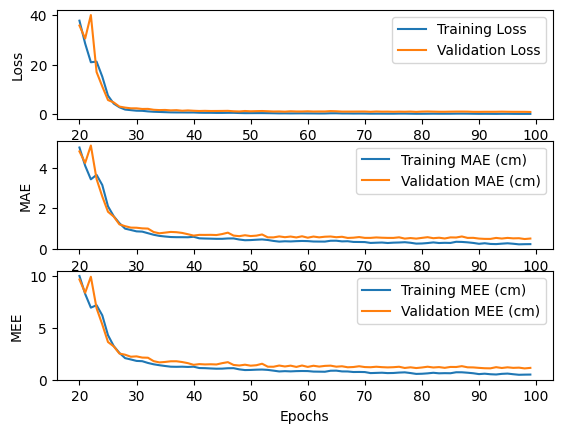

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

We now do a simple assessment on the quality of the predictions: given an input-output couple $(x, y = [y_1, y_2, y_3])$, if $\tilde{y}$ is the value predicted by the model, we calculate the relative error: $\left[\dfrac{|y_1 - \tilde{y_1} + \epsilon|}{|y_1 + \epsilon|}, \dfrac{|y_2 - \tilde{y_2} + \epsilon|}{|y_2 + \epsilon|}, \dfrac{|y_3 - \tilde{y_3} + \epsilon|}{|y_3 + \epsilon|}\right]$, where $\epsilon = 10^{-8}$ is a small constant to avoid dividing by $0$.

4/4 [==============================] - 0s 18ms/step
103 103 103
103 103 103
x-axis: mean = 0.7428003107637113, std = 2.8010074901888102
y-axis: mean = 0.20335181232783786, std = 1.3110601344911816
z-axis: mean = 0.01841422225500986, std = 0.020374257210571563


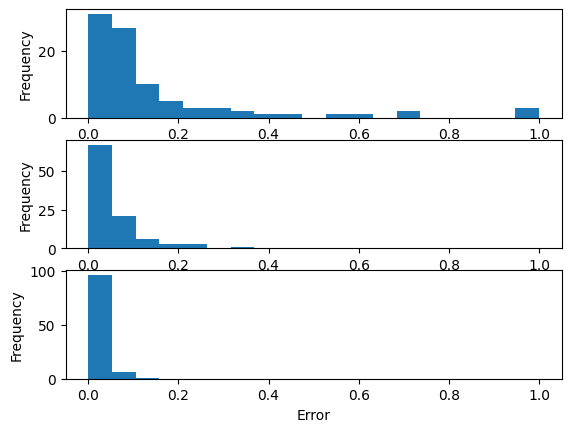

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.5045107007026672
Std of MAE: 0.48121416568756104
Mean of MEE: 1.126491438722753
Std of MEE: 1.1753036833417263


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.92267489 0.28891758 0.30193966]
Std of Distance along axes: [1.20655964 0.30983641 0.26938275]


Now we save model and history:

In [ ]:
model.save('baseVGG')

In [ ]:
json.dump(history.history, open('baseVGG.json', 'w'))

Free up space:

In [ ]:
del model

### With 270x480 images


In [ ]:
images, tip_pos = get_dataset(target_size_perc=0.25, force_resize=False, rescale_coordinates=100)

Now we do *train-test split* with a validation percentage of $20\%$.

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
del images

In [ ]:
model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(270, 480, 3)),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(256, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(256, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [ ]:
model.compile(
    loss='mean_squared_error', metrics=['MeanAbsoluteError', mean_euclidean_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 270, 480, 8)       392       
                                                                 
 conv2d_21 (Conv2D)          (None, 270, 480, 8)       1032      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 135, 240, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 135, 240, 16)      2064      
                                                                 
 conv2d_23 (Conv2D)          (None, 135, 240, 16)      4112      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 67, 120, 16)      0         
 g2D)                                                 

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 14s 568ms/step - loss: 275.3352 - mean_absolute_error: 12.4285 - mean_euclidean_error: 25.6532 - val_loss: 159.4732 - val_mean_absolute_error: 10.6323 - val_mean_euclidean_error: 21.7665
Epoch 2/100
10/10 [==============================] - 2s 191ms/step - loss: 143.3096 - mean_absolute_error: 9.9328 - mean_euclidean_error: 20.5324 - val_loss: 49.2443 - val_mean_absolute_error: 5.7229 - val_mean_euclidean_error: 11.6207
Epoch 3/100
10/10 [==============================] - 2s 186ms/step - loss: 74.8666 - mean_absolute_error: 7.3294 - mean_euclidean_error: 14.6400 - val_loss: 64.9889 - val_mean_absolute_error: 6.8220 - val_mean_euclidean_error: 12.9065
Epoch 4/100
10/10 [==============================] - 2s 175ms/step - loss: 46.1678 - mean_absolute_error: 5.6456 - mean_euclidean_error: 11.3251 - val_loss: 52.3992 - val_mean_absolute_error: 6.1210 - val_mean_euclidean_error: 11.6805
Epoch 5/100
10/10 [==============================] - 2

Now we plot the obtained results:

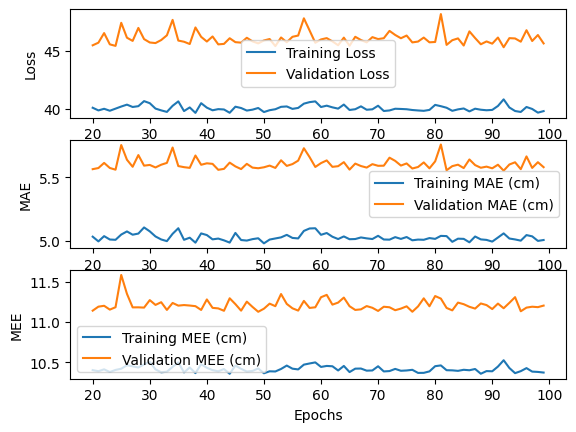

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 73ms/step
103 103 103
103 103 103
x-axis: mean = 1.226972689208091, std = 1.179927581072926
y-axis: mean = 0.994443614868533, std = 0.3116978695826056
z-axis: mean = 0.19806156503484557, std = 0.18391705936226843


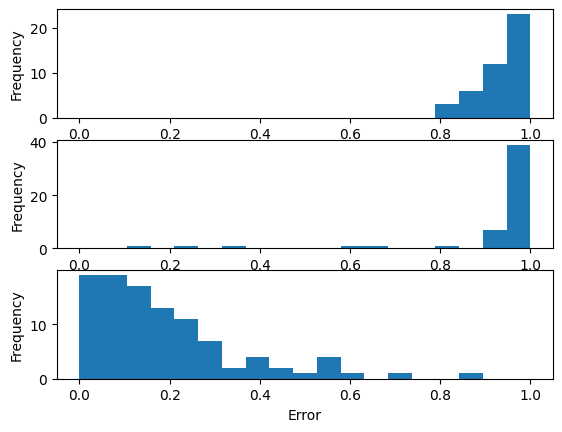

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 5.580334186553955
Std of MAE: 1.856224775314331
Mean of MEE: 11.204650063527417
Std of MEE: 3.377047300863154


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [6.40389718 7.04253709 3.29456927]
Std of Distance along axes: [3.78954659 3.97447791 2.30869642]


Now we save model and history:

In [ ]:
model.save('baseVGG270x480')

In [ ]:
json.dump(history.history, open('baseVGG270x480.json', 'w'))

Free up space:

In [ ]:
del model